## Sample transmission example

In this example we will calculate cross-sections and neutron transmission through various metals used for sample holders

## Preamble
Install dependencies and prepare plots. Feel free to edit as you wish:

In [1]:
#By default we only do pip installs on Google Colab, but you
#can set the variable in the next line to True if you need it:
always_do_pip_installs = False
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if always_do_pip_installs or google_colab:
    from importlib.util import find_spec as _fs
    if not _fs('NCrystal'):
        %pip -q install ncrystal ipympl numpy matplotlib gemmi spglib
#enable inline and interactive matplotlib plots:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
%matplotlib ipympl
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  3009007, "too old NCrystal found"
NC.test() #< quick unit test that installation works

Tests completed succesfully


### Additional modules:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

## Preparing a list of elemental metals
Before we start, we collect here for convenience a small list of elemental metals, and make it easy to get cfg-strings or loaded materials corresponding to those. Notice that we add a fall-back solution of unstructured solids (i.e. free-gas modelling) for elements not in the list:

In [3]:
element_2_ncmat = [{'Ni': 'Ni_sg225.ncmat', 'Cu':'Cu_sg225.ncmat',
                    'Fe': 'Fe_sg229_Iron-alpha.ncmat', 'Si':'Si_sg227.ncmat',
                    'C':'C_sg194_pyrolytic_graphite.ncmat',
                    'Al':'Al_sg225.ncmat', 'Ti':'Ti_sg194.ncmat',
                    'Cr':'Cr_sg229.ncmat', 'Mo':'Mo_sg229.ncmat'}]

def get_elemental_metal_cfgstr( element ):
  cfgstr = element_2_ncmat[0].get(element)
  if not cfgstr:
      #Fallback (using dummy density value)
      print(f"Warning: Using free-gas approximation for {element}")
      cfgstr=f'solid::{element}/1gcm3'
  return cfgstr

def load_metal( element ):
    return NC.load(get_elemental_metal_cfgstr( element ))

### Adding missing materials (Manganese)

NCrystal does not currently have metallic Manganese in the standard library. This is in principle not a big deal, since it is dominated by absorption, so defining it by `solid::Mn/6.33gcm3` would likely be perfectly fine. However, we remind ourselves how we can easily add a material with the proper crystal structure once we have found it in an online database:


In [4]:
from NCrystal.ncmat import NCMATComposer
os.environ['NCRYSTAL_ONLINEDB_CACHEDIR'] = './ncrystal_onlinedb_filecache'
NCMATComposer('codid::9008590').register_as('Mn_from_cif.ncmat')
element_2_ncmat[0]['Mn']='Mn_from_cif.ncmat'

Querying the Crystallography Open Database for entry 9008590
Adding cod_9008590.cif to local file cache in $NCRYSTAL_ONLINEDB_CACHEDIR
Attempting to load CIF data with gemmi
Self-consistency of structure was verified by spglib


### Cross sections of elemental metals
For reference, let us plot cross sections of some elemental metals:

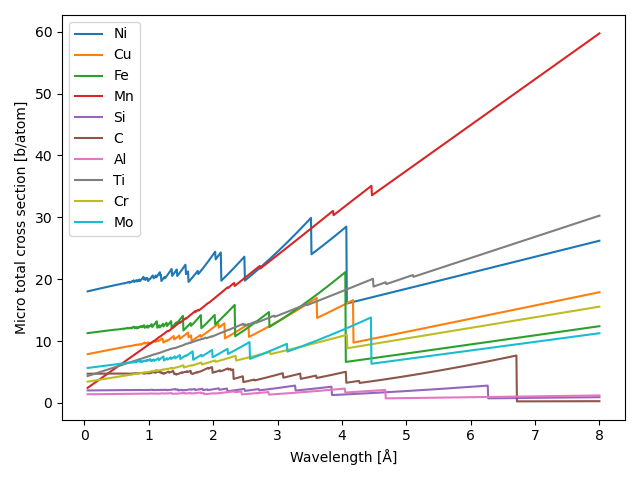

In [5]:
elements = ['Ni', 'Cu', 'Fe', 'Mn', 'Si', 'C', 'Al', 'Ti', 'Cr', 'Mo']
wls = np.linspace(0.05, 8, 1000)

plt.figure()
for element in elements:
  plt.plot(wls, load_metal(element).xsect(wl=wls), label=element)
plt.legend()
plt.xlabel('Wavelength [Å]')
plt.ylabel('Micro total cross section [b/atom]')
plt.show()

## Example #1

Calculate the cross-section and transmission through Inconel. We will model the alloy as a mixture of elemental metals.

This example is based on a transmission experiment planned at ISIS on NaOH. NaOH in liquid form at high temperatures is considered as moderator for compact molten salt reactors. However, NaOH is also corrosive and it is difficult to find sample holder materials that are both sufficiently temperature and corrosion resistant. An additional constraint is that the sample holder should exhibit low neutron absorption and scattering in order to minimize the impact on the measurement. Inconel alloy 625 was found to be a good solution for this problem. More information can also be found in the following paper, https://doi.org/10.1051/epjconf/202328417009.

Create now a material from the elements and plot the cross section and transmission.

Here we do it by manually adding up individual cross sections, afterwards we will try to build up an NCrystal-cfg string instead.

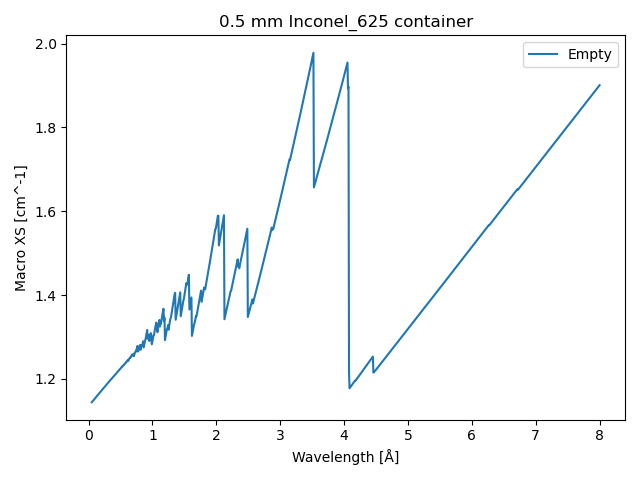

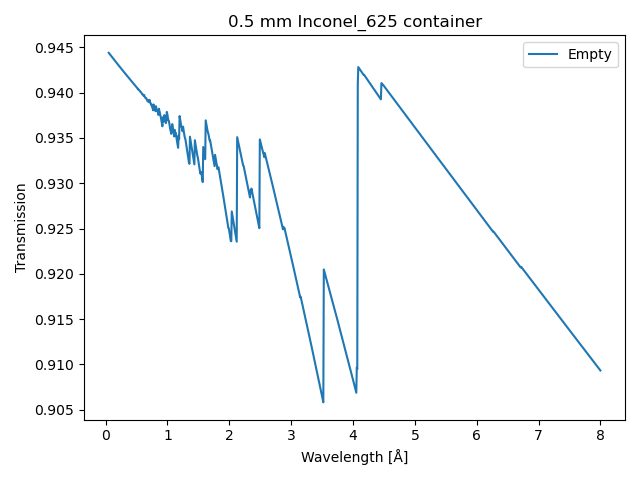

In [6]:
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

material = {'Name': 'Inconel_625',
            'Density': 8.440, 
            'Composition': {'Ni': 6.317E-1, 'Cu': 3.333E-3, 'Fe': 5.000E-2, 
                            'Mn': 5.000E-3, 'Si': 5.000E-3, 'C': 1.000E-3,
                            'Al': 0.000E0, 'Ti': 4.000E-3, 'Cr': 2.000E-1,
                            'Mo': 1.000E-1}
           }

container_thickness = 0.05 # cm

xs = np.zeros(len(wls))
for element, fraction in material['Composition'].items():
  N = material['Density']*fraction*NC.constants.constant_avogadro*1e-24/NC.atomDB(element).averageMassAMU()
  xs += N*load_metal(element).xsect(wl=wls)

plt.plot(wls,xs, label='Empty')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Macro XS [cm^-1]')
plt.title(f'{container_thickness*10} mm {material["Name"]} container')
a = plt.legend()
plt.figure()
plt.plot(wls,np.exp(-xs*container_thickness), label='Empty')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Transmission')
plt.title(f'{container_thickness*10} mm {material["Name"]} container')
a = plt.legend()

In case you need the material outside this notebook (e.g. in a McStas simulation), let us build up an NCrystal cfg-string for the material using the `"phases<...>"` syntax for multiphase materials. One caveat here is that it currently needs volume-fractions and not mass-fractions, so we need to calculate those. Another caveat is of course that we only created `Mn_from_cif.ncmat` in this notebook, so you would have to write that file to disk and make it available wherever you needed it (obviously it might be easier to simply use `solid::Mn/6.33gcm3` for Manganese in this case, since the absorption is anyway domination).

phases<0.5935321382931467*Ni_sg225.ncmat
       & 0.0031223546964853186*Cu_sg225.ncmat
       & 0.05320793603010228*Fe_sg229_Iron-alpha.ncmat
       & 0.0066113954534235304*Mn_from_cif.ncmat
       & 0.017965832506272532*Si_sg227.ncmat
       & 0.0037020388200289293*C_sg194_pyrolytic_graphite.ncmat
       & 0.0074377205665642505*Ti_sg194.ncmat
       & 0.2325163517851714*Cr_sg229.ncmat
       & 0.08190423184880506*Mo_sg229.ncmat>;density=8.44gcm3


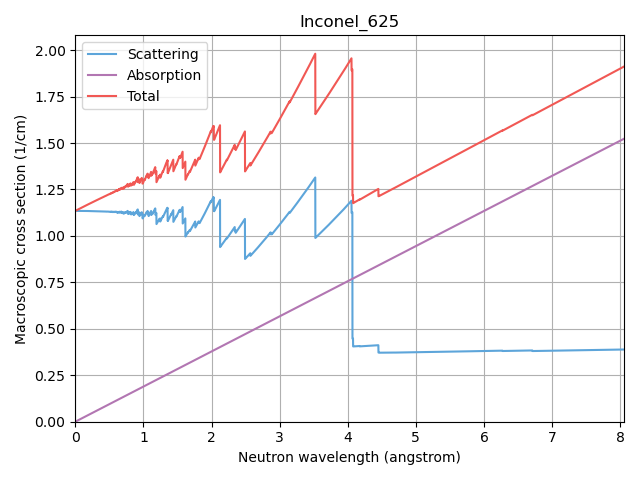

In [7]:
def mat2cfgstr( matdef, compact = True ):
    density_gcm3 = matdef['Density']
    #Let us collect massfractions, densities and cfgstrings of the phases in a list:
    compos = [(massfrac,
               load_metal(element).info.density,
               get_elemental_metal_cfgstr(element) )
               for element,massfrac in matdef['Composition'].items()]
    #The volume fractions are proportional to the
    #mass fractions divided by the densities:
    volfracs = [ massfrac/density for massfrac,density,cfgstr in compos ]
    #normalise:
    volfracs = [ e/sum(volfracs) for e in volfracs[:] ]
    #Finally compose the cfg-string:
    parts=[]
    for (massfrac,density,cfgstr),volfrac in zip(compos,volfracs):
        if volfrac > 0.0:
            parts.append(f'{volfrac}*{cfgstr}')
    set='&' if compact else '\n       & '
    return 'phases<' + '\n       & '.join(parts) + f'>;density={density_gcm3}gcm3'
print( mat2cfgstr(material,compact=False) )
NC.load(mat2cfgstr(material)).plot(title=material['Name'],xsmode='macroscopic')

## Exercise #1

Compute the cross-section and transmission through Aluminium alloys Al-7075 and Al-6061 based on Table 2 in https://doi.org/10.1016/j.nima.2023.168127

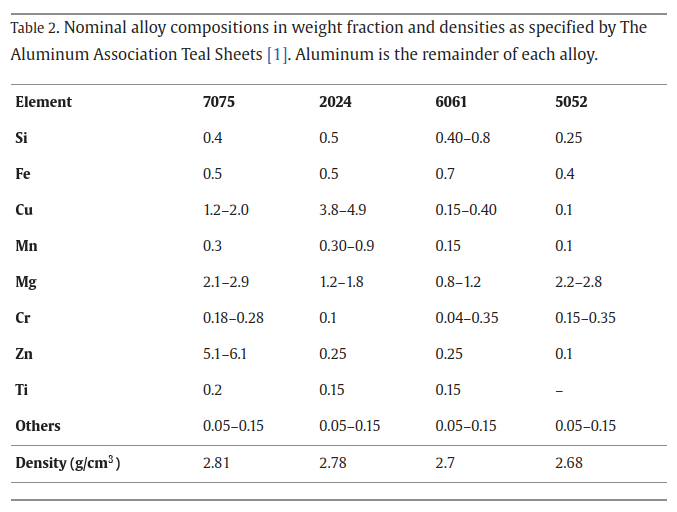

In [8]:
## Your code